In [33]:
import pandas as pd
import requests
import folium
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
url_gares = "https://ressources.data.sncf.com/api/v2/catalog/datasets/liste-des-gares/exports/json?limit=-1&offset=0&timezone=UTC"
gares = requests.get(url_gares)
wb_gares = gares.json()

df_gares = pd.DataFrame(wb_gares)
df_gares.head(10)

,code_uic,libelle,fret,voyageurs,code_ligne,rg_troncon,pk,commune,departemen,idreseau,idgaia,x_l93,y_l93,x_wgs84,y_wgs84,c_geo,geo_point_2d,geo_shape
0,87755223,Bandol,N,O,930000,1,050+607,BANDOL,VAR,3077,29a5a626-dfbc-11e3-a2ff-01a464e0362d,923833.7169,6.230702e+06,5.749816,43.140491,"{'lon': 5.749815526229215, 'lat': 43.140491048...","{'lon': 5.749815526229215, 'lat': 43.140491047...","{'type': 'Feature', 'geometry': {'coordinates'..."
1,87696179,Pouilly-sur-Loire,O,O,750000,1,214+004,POUILLY-SUR-LOIRE,NIEVRE,6141,297a4c76-dfbc-11e3-a2ff-01a464e0362d,697358.2537,6.686913e+06,2.965051,47.282528,"{'lon': 2.965051211539136, 'lat': 47.282528482...","{'lon': 2.965051211539134, 'lat': 47.282528481...","{'type': 'Feature', 'geometry': {'coordinates'..."
2,87718155,Arbois,N,O,880000,1,401+119,ARBOIS,JURA,2912,28faadb4-dfbc-11e3-a2ff-01a464e0362d,910253.9023,6.649514e+06,5.763090,46.912701,"{'lon': 5.763090017438219, 'lat': 46.912701321...","{'lon': 5.763090017438219, 'lat': 46.912701320...","{'type': 'Feature', 'geometry': {'coordinates'..."
3,87784488,Cases-de-Pène,O,N,676000,1,463+765,ESPIRA-DE-L'AGLY,PYRENEES-ORIENTALES,3499,d9c2a8a8-6667-11e3-89ff-01f464e0362d,683051.0831,6.186628e+06,2.793117,42.778983,"{'lon': 2.793116620024166, 'lat': 42.778983389...","{'lon': 2.7931166200241657, 'lat': 42.77898338...","{'type': 'Feature', 'geometry': {'coordinates'..."
4,87481002,Nantes,O,O,519000,1,428+284,NANTES,LOIRE-ATLANTIQUE,5736,c01d1406-f312-11e3-90ff-015864e0362d,358259.4680,6.690441e+06,-1.518766,47.226239,"{'lon': -1.518765979566461, 'lat': 47.22623886...","{'lon': -1.5187659795664639, 'lat': 47.2262388...","{'type': 'Feature', 'geometry': {'coordinates'..."
5,87142125,Culmont-Chalindrey,O,O,843000,1,390+773,CHALINDREY,HAUTE-MARNE,3902,2953a9de-dfbc-11e3-a2ff-01a464e0362d,883044.6500,6.748177e+06,5.445906,47.808467,"{'lon': 5.445906370699546, 'lat': 47.808466512...","{'lon': 5.4459063706995465, 'lat': 47.80846651...","{'type': 'Feature', 'geometry': {'coordinates'..."
6,87751743,La Penne-sur-Huveaune,N,O,930000,1,012+448,LA PENNE-SUR-HUVEAUNE,BOUCHES-DU-RHONE,4724,d9aade98-6667-11e3-89ff-01f464e0362d,904260.7039,6.246100e+06,5.515554,43.284789,"{'lon': 5.515553840898035, 'lat': 43.284789141...","{'lon': 5.5155538408980345, 'lat': 43.28478914...","{'type': 'Feature', 'geometry': {'coordinates'..."
7,87732404,Gannat,O,O,790000,1,378+390,GANNAT,ALLIER,4260,d9717cca-6667-11e3-89ff-01f464e0362d,715826.9804,6.555335e+06,3.204865,46.097618,"{'lon': 3.204865220044901, 'lat': 46.097617863...","{'lon': 3.2048652200449, 'lat': 46.09761786249...","{'type': 'Feature', 'geometry': {'coordinates'..."
8,87590331,Haluchère-Batignolles,N,O,519000,1,433+010,NANTES,LOIRE-ATLANTIQUE,152499,e048856a-19bf-11e5-82ff-01fc64e0362d,358119.6208,6.692998e+06,-1.522545,47.249147,"{'lon': -1.5225453757032792, 'lat': 47.2491474...","{'lon': -1.5225453757032819, 'lat': 47.2491474...","{'type': 'Feature', 'geometry': {'coordinates'..."
9,87396671,La Chartre-sur-le-Loir,O,N,500000,1,201+426,LA CHARTRE-SUR-LE-LOIR,SARTHE,4628,d99275ae-6667-11e3-89ff-01f464e0362d,518806.9734,6.740576e+06,0.581929,47.740608,"{'lon': 0.5819290793774801, 'lat': 47.74060836...","{'lon': 0.581929079377478, 'lat': 47.740608359...","{'type': 'Feature', 'geometry': {'coordinates'..."


In [4]:
url_freq_gares = "https://ressources.data.sncf.com/api/v2/catalog/datasets/frequentation-gares/exports/json?limit=-1&offset=0&timezone=UTC"
freq_gares = requests.get(url_freq_gares)
wb_freq_gares = freq_gares.json()

df_freq_gares = pd.DataFrame(wb_freq_gares)
df_freq_gares.head(10)

,nom_gare,code_uic_complet,code_postal,segmentation_drg,total_voyageurs_2021,total_voyageurs_non_voyageurs_2021,total_voyageurs_2020,total_voyageurs_non_voyageurs_2020,total_voyageurs_2019,total_voyageurs_non_voyageurs_2019,total_voyageurs_2018,total_voyageurs_non_voyageurs_2018,totalvoyageurs2017,total_voyageurs_non_voyageurs_2017,total_voyageurs_2016,total_voyageurs_non_voyageurs_2016,total_voyageurs_2015,total_voyageurs_non_voyageurs_2015
0,Abbaretz,87481614,44170,c,27466,27466,22773,22773,38473,38473,38027,38027,35637,35637,33021,33021,35989,35989
1,Agay,87757559,83530,c,25094,25094,15390,15390,22284,22284,15093,15093,14154,14154,19240,19240,19121,19121
2,Aigueperse,87734129,63260,c,55143,55143,50677,50677,75954,75954,70745,70745,77218,77218,78088,78088,75873,75873
3,Aigues-Mortes,87775858,30220,c,8201,8201,5683,5683,6146,6146,5311,5311,4822,4822,3546,3546,3917,3917
4,Aime - La Plagne,87741769,73210,b,60161,75201,71603,89504,105825,132281,104267,130333,106398,132998,105331,131663,101243,126554
5,Aix-les-Bains le Revard,87741132,73100,b,1322646,1653308,988929,1236162,1515076,1893845,1287574,1609468,1370409,1713011,1295717,1619647,1299301,1624127
6,Aixe-sur-Vienne,87592667,87700,c,11887,11887,8611,8611,10016,10016,5734,5734,8524,8524,8301,8301,8442,8442
7,Albi,87615005,81000,b,391271,489089,287025,358781,415630,519537,368147,460184,432819,541024,392651,490814,412872,516090
8,Albias,87613398,82350,c,19376,19376,11378,11378,11386,11386,8780,8780,11579,11579,9415,9415,10586,10586
9,Altkirch,87182238,68130,b,250081,266043,217365,231239,322676,343273,303746,323134,310531,330353,286839,305148,284515,302676


In [10]:
df_freq_gares.rename(columns = {'code_uic_complet':'code_uic'}, inplace = True)

In [11]:
#nous avons plus de données sur les gares que sur la frequentation
print(len(df_gares))
print(len(df_freq_gares))

3819
2970


In [79]:
left_merged = pd.merge(df_gares, df_freq_gares, how="left", on=["code_uic"])
df_gares_merged = left_merged[['code_uic','total_voyageurs_non_voyageurs_2020', 'libelle', 'x_wgs84','y_wgs84']]

(array([3.208e+03, 9.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00]),
 array([1.00000000e+00, 1.52624522e+07, 3.05249034e+07, 4.57873546e+07,
        6.10498058e+07, 7.63122570e+07, 9.15747082e+07, 1.06837159e+08,
        1.22099611e+08, 1.37362062e+08, 1.52624513e+08]),
 <BarContainer object of 10 artists>)

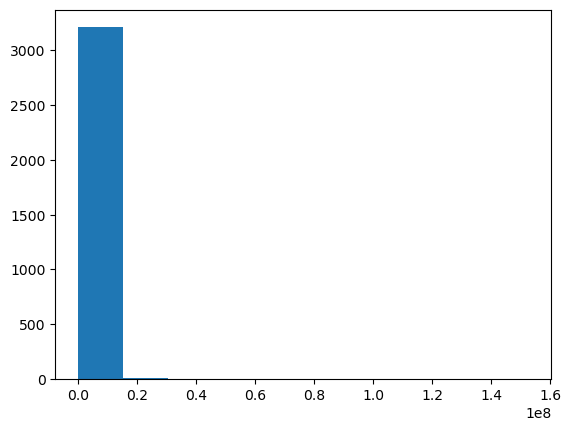

In [80]:
#gérer les cas 0 et NaN
df_gares_merged = df_gares_merged.dropna()
df_gares_merged = df_gares_merged.drop(df_gares_merged[df_gares_merged['total_voyageurs_non_voyageurs_2020']==0].index)
plt.hist(df_gares_merged['total_voyageurs_non_voyageurs_2020'])

(array([ 15.,  30.,  90., 257., 628., 924., 764., 392., 116.,   9.]),
 array([ 0.        ,  1.88434913,  3.76869826,  5.65304739,  7.53739652,
         9.42174565, 11.30609478, 13.19044391, 15.07479304, 16.95914217,
        18.8434913 ]),
 <BarContainer object of 10 artists>)

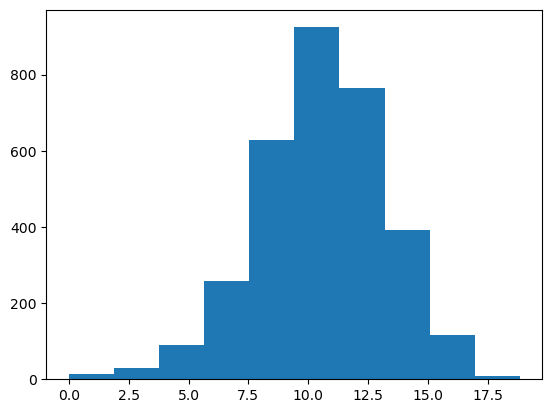

In [81]:
plt.hist(np.log(df_gares_merged['total_voyageurs_non_voyageurs_2020']))
#mieux pour travailler sur les frequentations

In [82]:
df_gares_principales = df_gares_merged[np.log(df_gares_merged['total_voyageurs_non_voyageurs_2020'])>= 15]
df_gares_principales

,code_uic,total_voyageurs_non_voyageurs_2020,libelle,x_wgs84,y_wgs84
4,87481002,11334114.0,Nantes,-1.518766,47.226239
11,87313874,4991907.0,Amiens,2.309276,49.889917
97,87681007,5418465.0,Corbeil-Essonnes,2.468507,48.609506
145,87113217,8762930.0,Noisy-le-Sec,2.459922,48.896750
223,87547000,13602554.0,Paris-Austerlitz,2.367038,48.840495
...,...,...,...,...,...
3771,87545244,21871129.0,Juvisy,2.383583,48.689257
3773,87276196,4696178.0,Garges-Sarcelles,2.391165,48.977257
3792,87271437,3831144.0,Vert-Galant,2.566815,48.944286
3806,87545236,3789578.0,Savigny-sur-Orge,2.350700,48.674472


In [83]:
m = folium.Map(location=[45.8666, 2.3333], min_zoom=3, max_zoom=14, zoom_start=5.3, tiles = 'Stamen Terrain')
for i in df_gares_principales.index:
    tooltip = df_gares_principales['libelle'][i]
    folium.Marker([df_gares_principales['y_wgs84'][i],df_gares_principales['x_wgs84'][i]], popup=df_gares_principales['libelle'][i], tooltip=tooltip).add_to(m)
m